In [51]:
import numpy as np
import matplotlib.pylab as plt
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2theta-omega scan

- export data to '.csv' file

In [52]:
from two_theta_values import list_peak, w_K_alpha1_Cu

In [54]:
def annotates_peak(peaks, color='red', I_level=1e3, symbol=''):
    for p in peaks:
        angle = p['2𝜃 (deg)']

        if angle > np.max(twth):
            break

        plt.axvline(x=angle, linewidth=1,
                    color=color, alpha=0.7)

        linename = p['hkl'].replace('(', '').replace(')', '')
        text_y_position = I_level+300*np.gcd.reduce(p['hkl_tuple'])
        plt.text(angle, text_y_position, linename,
                     rotation=0, color=color);

In [55]:
filename = 'scan_th2th_ARB_145deg_10s.csv'

# Load data
data_directory = 'data'
filepath = os.path.join(data_directory, filename)
data = np.genfromtxt(filepath,
                     skip_header=32,
                     delimiter=',')

twth = data[:, 0]
I = data[:, 1]

## Graph

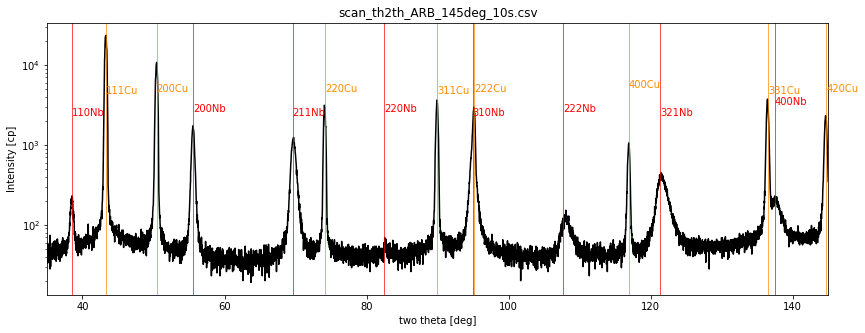

In [56]:
plt.figure(figsize=(14, 5))
plt.xlabel('two theta [deg]')
plt.ylabel('Intensity [cp]')

plt.semilogy(twth, I, 'k')
plt.xlim([twth.min(), twth.max()])
plt.title(filename)

peaks_Nb = list_peak('Nb', w_K_alpha1_Cu, twoth_max=np.max(twth))
annotates_peak(peaks_Nb, color='red', I_level=2e3, symbol='Nb')

peaks_Cu = list_peak('Cu', w_K_alpha1_Cu, twoth_max=np.max(twth))
annotates_peak(peaks_Cu, color='darkorange', I_level=4e3, symbol='Cu')

## Peak parameters estimation (fit)

In [57]:
import peakfit as pf

In [58]:
def fit_peaks(peak_list):
    # !!  mutable 

    for peak in peak_list:
        peak_center = peak['2𝜃 (deg)']
        window_size = 6 # in twth unit (deg.)

        mask = np.logical_and(twth > peak_center - window_size/2,
                              twth < peak_center + window_size/2)

        x, y = twth[mask], I[mask]
        try:
            results, fit = pf.peakfit(x, y,
                                      pf.PseudoVoigt()#x0=peak_center, fwhm=1.5),
                                      )#pf.Gauss())
            peak['fit_param'] = results[0]
            peak['fit_function'] = (x, fit(x))
            
            pf.plot_results(x, y, results, fit,
                            save_path='./output_fit/',
                            save_name=peak['hkl'])

        except RuntimeError:
            print('fit error for', peak['hkl'])
            pf.plot_results(x, y,
                            save_path='./output_fit/',
                            save_name=peak['hkl'])

fit error for (220)Nb


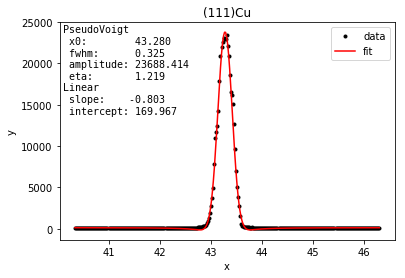

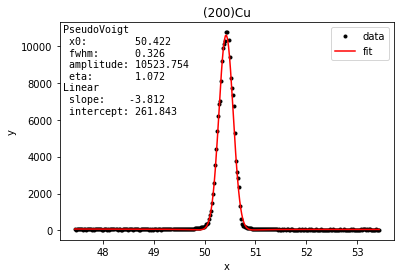

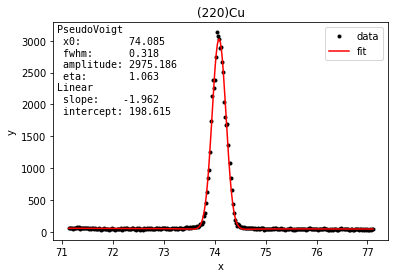

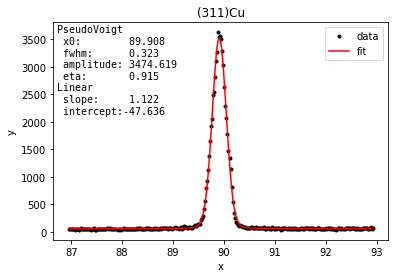

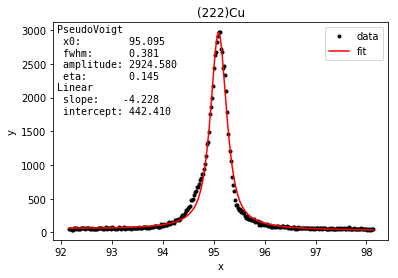

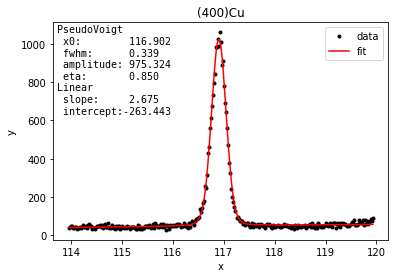

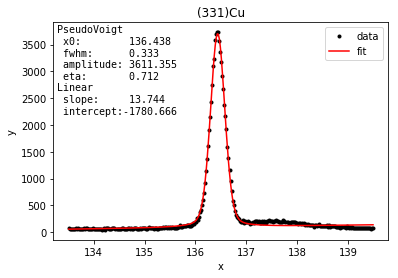

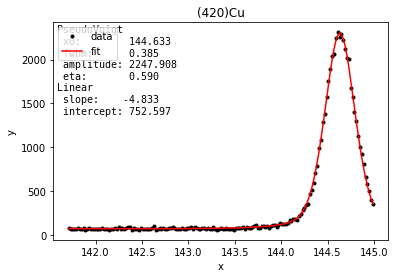

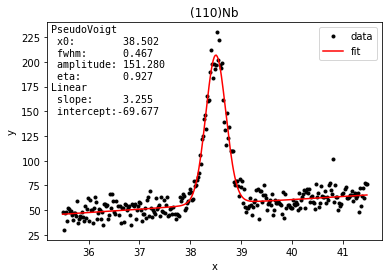

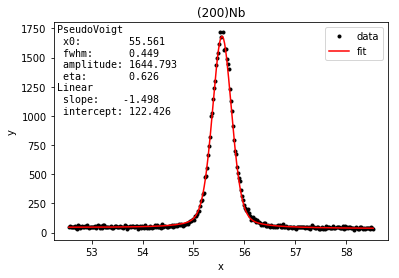

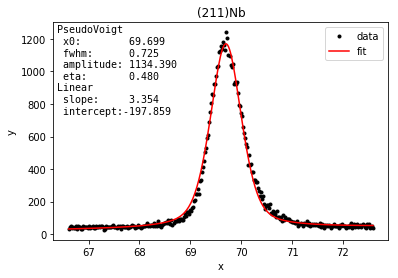

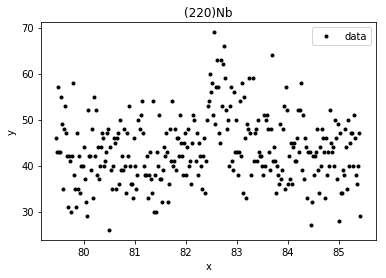

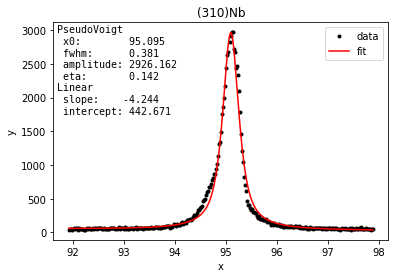

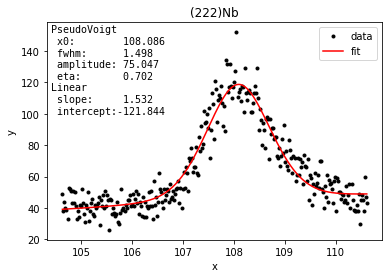

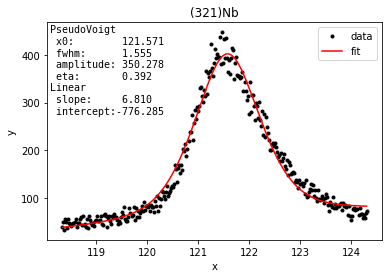

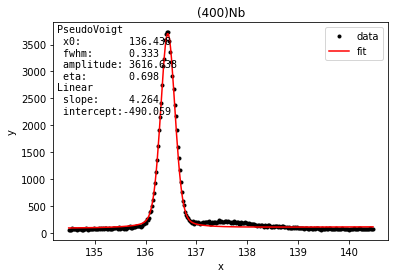

In [59]:
fit_peaks(peaks_Cu)
fit_peaks(peaks_Nb)

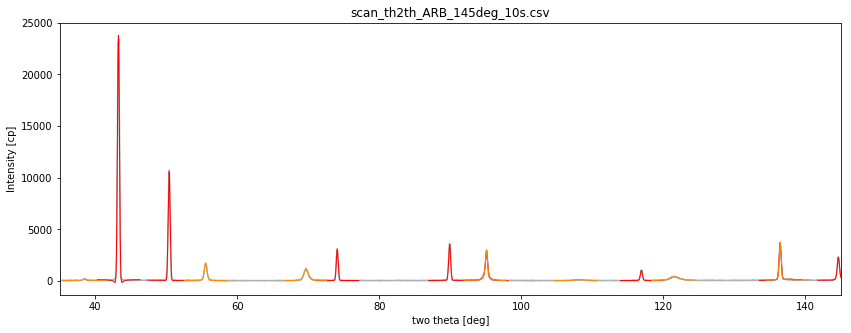

In [60]:
plt.figure(figsize=(14, 5))
plt.xlabel('two theta [deg]')
plt.ylabel('Intensity [cp]')

plt.plot(twth, I, 'k', alpha=0.3)
plt.xlim([twth.min(), twth.max()])
plt.title(filename);

for peak in peaks_Cu:
    if not 'fit_function' in peak:
        continue
    x, y = peak['fit_function']
    plt.plot(x, y, '-r', linewidth=1)
    
for peak in peaks_Nb:
    if not 'fit_function' in peak:
        continue
    x, y = peak['fit_function']
    plt.plot(x, y, '-', color='darkorange', linewidth=1)

In [61]:
from tabulate import tabulate

In [62]:
lmbda = w_K_alpha1_Cu  # wavelength, Angström
def DebyeScherrer(params):
    K = 0.9  #  dimensionless shape factor
    theta_rad = params['x0']/2 *np.pi/180
    beta_rad = params['fwhm'] *np.pi/180
    return K*lmbda/(beta_rad*np.cos(theta_rad))

def peak_summary(peaks):
    data_table = [{'hkl':p['hkl'],
                   'x0(deg)':p['fit_param']['x0'],
                   'fwhm(deg)':p['fit_param']['fwhm'],
                   'fwhm_std':p['fit_param']['fwhm_std'],
                   'DebyeScherrer(Å)':DebyeScherrer(p['fit_param'])
                  } if 'fit_param' in p
                  else {'hkl':p['hkl']} 
                  for p in peaks]
    return tabulate(data_table, headers='keys')
    

In [63]:
print(peak_summary(peaks_Cu))

hkl        x0(deg)    fwhm(deg)    fwhm_std    DebyeScherrer(Å)
-------  ---------  -----------  ----------  ------------------
(111)Cu    43.2795     0.324742  0.00179975             263.182
(200)Cu    50.4219     0.325722  0.00168168             269.575
(220)Cu    74.0846     0.317663  0.00222591             313.314
(311)Cu    89.9084     0.323467  0.00163015             347.05
(222)Cu    95.0955     0.380968  0.00599809             308.942
(400)Cu   116.902      0.338624  0.00220675             448.382
(331)Cu   136.438      0.333226  0.00185565             642.498
(420)Cu   144.633      0.384673  0.00185579             679.88


In [64]:
print(peak_summary(peaks_Nb))

hkl        x0(deg)    fwhm(deg)    fwhm_std    DebyeScherrer(Å)
-------  ---------  -----------  ----------  ------------------
(110)Nb    38.5018     0.467319  0.0109529             180.065
(200)Nb    55.5606     0.449156  0.00191488            199.913
(211)Nb    69.6993     0.724868  0.00593764            133.547
(220)Nb
(310)Nb    95.0955     0.38105   0.00601137            308.876
(222)Nb   108.086      1.49837   0.0445498              90.2953
(321)Nb   121.571      1.55534   0.023425              104.65
(400)Nb   136.438      0.333008  0.00210037            642.92
